# Santema 
- oxidation of glucose and N-acetylglucosamine is catalyzed by NagOx

no time values were given?

## Daten über das Spreadsheet template einlesen

In [26]:
import pyenzyme as pe
import pandas as pd
import lmfit as lm
import numpy as np
import matplotlib.pyplot as plt

In [27]:
enzmldoc = pe.EnzymeMLDocument.fromTemplate("/Users/benjamin/Masterarbeit/Santema/round1/Santema_new.xlsm")

/Users/benjamin/miniforge3/envs/localpyenzyme/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/localpyenzyme/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/localpyenzyme/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/localpyenzyme/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin/miniforge3/envs/localpyenzyme/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/benjamin

In [28]:
enzmldoc.printMeasurements()

>>> Measurement m0: 1.0
    s1 | initial conc: 10.0 mmole / l 	| #replicates: 0
    s0 | initial conc: 250.0 nmole / l 	| #replicates: 0
    s4 | initial conc: 0.0 nmole / l min 	| #replicates: 3
    p0 | initial conc: 500.0 pmole / l 	| #replicates: 0
>>> Measurement m1: 2.0
    s1 | initial conc: 5.0 mmole / l 	| #replicates: 0
    s0 | initial conc: 250.0 nmole / l 	| #replicates: 0
    s4 | initial conc: 0.0 nmole / l min 	| #replicates: 3
    p0 | initial conc: 500.0 pmole / l 	| #replicates: 0
>>> Measurement m2: 3.0
    s1 | initial conc: 2.5 mmole / l 	| #replicates: 0
    s0 | initial conc: 250.0 nmole / l 	| #replicates: 0
    s4 | initial conc: 0.0 nmole / l min 	| #replicates: 3
    p0 | initial conc: 500.0 pmole / l 	| #replicates: 0
>>> Measurement m3: 4.0
    s1 | initial conc: 1.0 mmole / l 	| #replicates: 0
    s0 | initial conc: 250.0 nmole / l 	| #replicates: 0
    s4 | initial conc: 0.0 nmole / l min 	| #replicates: 3
    p0 | initial conc: 500.0 pmole / l 	| #repli

In [29]:
reactant_id = 's4'

In [30]:
data = enzmldoc.exportMeasurementData(species_ids=reactant_id)
data = pd.concat([meas["data"] for meas in data.values()])
data_rate = data[reactant_id].values.reshape(-1, len(data[reactant_id].values))

In [31]:
# Get substrate concentration
data = enzmldoc.exportMeasurementData(species_ids='s1')
data = [meas["initConc"]["s1"][0] for meas in enzmldoc.exportMeasurementData(species_ids='s1').values()]
data_s = np.array([])
for elem in data:
    for i in range(3):
        data_s = np.append(data_s, elem)

data_s_mirrored = data_s[::-1]

In [32]:
data_rate

array([[44.23, 46.3 , 45.78, 46.88, 47.18, 46.37, 44.7 , 44.62, 44.19,
        42.03, 41.14, 43.47, 37.61, 37.57, 37.29, 27.1 , 25.9 , 24.26,
        21.38, 20.69, 21.85, 12.36, 12.53, 12.61]])

In [33]:
data_s

array([10.  , 10.  , 10.  ,  5.  ,  5.  ,  5.  ,  2.5 ,  2.5 ,  2.5 ,
        1.  ,  1.  ,  1.  ,  0.5 ,  0.5 ,  0.5 ,  0.25,  0.25,  0.25,
        0.1 ,  0.1 ,  0.1 ,  0.05,  0.05,  0.05])

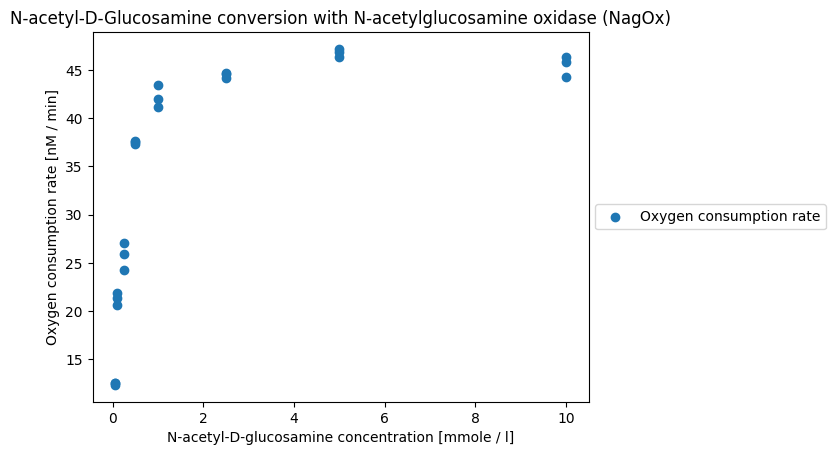

In [34]:
plt.scatter(data_s, data_rate, label="Oxygen consumption rate")
plt.title("N-acetyl-D-Glucosamine conversion with N-acetylglucosamine oxidase (NagOx)")
plt.xlabel("N-acetyl-D-glucosamine concentration [mmole / l]")
plt.ylabel("Oxygen consumption rate [nM / min]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Modeling

In [35]:
def michaelis_menten(w, params):
    
    s = w
    
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(s'):
    f = vmax * s / (km + s) # S'
    return f

In [36]:
def residuals(params, substrate_conc, rate_data):
    vmax = params["vmax"].value
    Km = params["Km"].value

    model = michaelis_menten(substrate_conc, params)

    return rate_data - model

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 24
    # variables        = 2
    chi-square         = 85.7167698
    reduced chi-square = 3.89621681
    Akaike info crit   = 34.5518717
    Bayesian info crit = 36.9079794
[[Variables]]
    vmax:  47.2024417 +/- 0.67547191 (1.43%) (init = 50)
    Km:    0.14692070 +/- 0.01041137 (7.09%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = 0.637


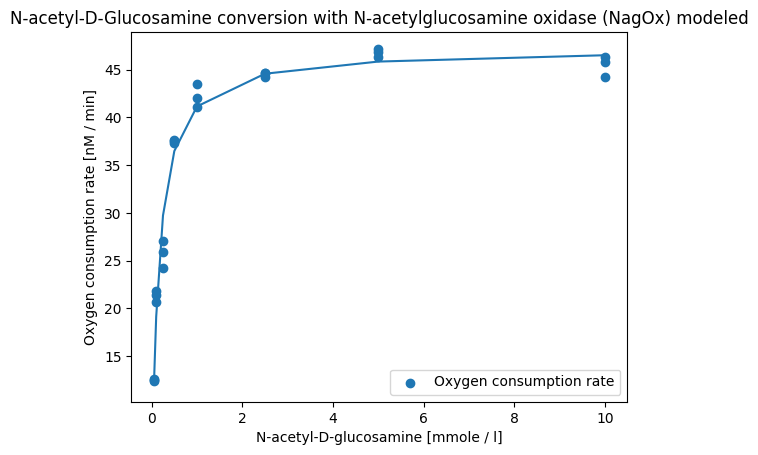

In [39]:
from cProfile import label


params = lm.Parameters()
params.add("vmax", value = 50, min=0.01, max=200)
params.add("Km", value = 0.2, min=0.001, max=10)

result =lm.minimize(residuals, params, args=(data_s, data_rate))
lm.report_fit(result)

fittedModel = michaelis_menten(data_s, result.params)
plt.plot(data_s, fittedModel)
plt.scatter(data_s, data_rate, label="Oxygen consumption rate")
plt.title("N-acetyl-D-Glucosamine conversion with N-acetylglucosamine oxidase (NagOx) modeled")
plt.xlabel("N-acetyl-D-glucosamine [mmole / l]")
plt.ylabel("Oxygen consumption rate [nM / min]")
plt.legend()

kcat (1/s) = vmax (mole / l min) / e (mole / l) <br>
kcat = 47,20 nmole/l*min / 0,5 nmole/l <br>
kcat = 94,4 1/min <br>
kcat = 94,4/min / 60        # turn into seconds <br>
kcat = 1,57 / s
data_rate2 = data_rate / 1000000

In [38]:
params = lm.Parameters()
params.add("vmax", value = 10, min=0.000001, max=50)
params.add("Km", value = 5, min=0.01, max=10)

result =lm.minimize(residuals, params, args=(data_s, data_rate2))
lm.report_fit(result)

fittedModel = michaelis_menten(data_s, result.params)
plt.plot(data_s, fittedModel)
plt.scatter(data_s, data_rate2)
plt.title("N-acetyl-D-Glucosamine conversion with N-acetylglucosamine oxidase (NagOx) modeled")
plt.xlabel("N-acetyl-D-glucosamine [mmole / l]")
plt.ylabel("Oxygen consumption rate [mM / min]")

NameError: name 'data_rate2' is not defined